In [116]:
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image, ImageDraw
from PIL.ImageOps import grayscale

from src.config import images
from src.dataset import DatasetVGG16

mask_data = pd.read_json("zurich/segmented/zurich_000000_000019_gtFine_polygons.json")
masked_img = Image.open("zurich/segmented/zurich_000000_000019_gtFine_color.png")
masked_img_label = Image.open("zurich/segmented/zurich_000000_000019_gtFine_labelIds.png")

img = Image.open("zurich/annotat/zurich_000000_000019_leftImg8bit.png")

In [231]:
categories = pd.Series([m['label'] for m in mask_data['objects']])

In [232]:
categories.unique()

array(['static', 'sky', 'building', 'vegetation', 'ground', 'road',
       'sidewalk', 'fence', 'pole', 'traffic light', 'traffic sign',
       'train', 'person', 'car', 'cargroup', 'dynamic', 'ego vehicle',
       'out of roi'], dtype=object)

In [233]:
import numpy as np
img_numpy = np.array(img)
img_numpy.dtype

dtype('uint8')

## Visulation avec les polygones

In [234]:
mask = np.array(mask_data['objects'][38]['polygon'])

In [250]:
img_draw = ImageDraw.Draw(img)
img_draw.polygon([tuple(p) for p in mask], outline="red", fill="red")
img.show()

## Retrouver les catégories à partir des labels de l'image

In [251]:
labels = np.array(masked_img_label)

In [282]:
np.unique(labels)

array([ 0,  1,  3,  4,  5,  6,  7,  8, 11, 13, 17, 19, 20, 21, 23, 24, 26,
       31], dtype=uint8)

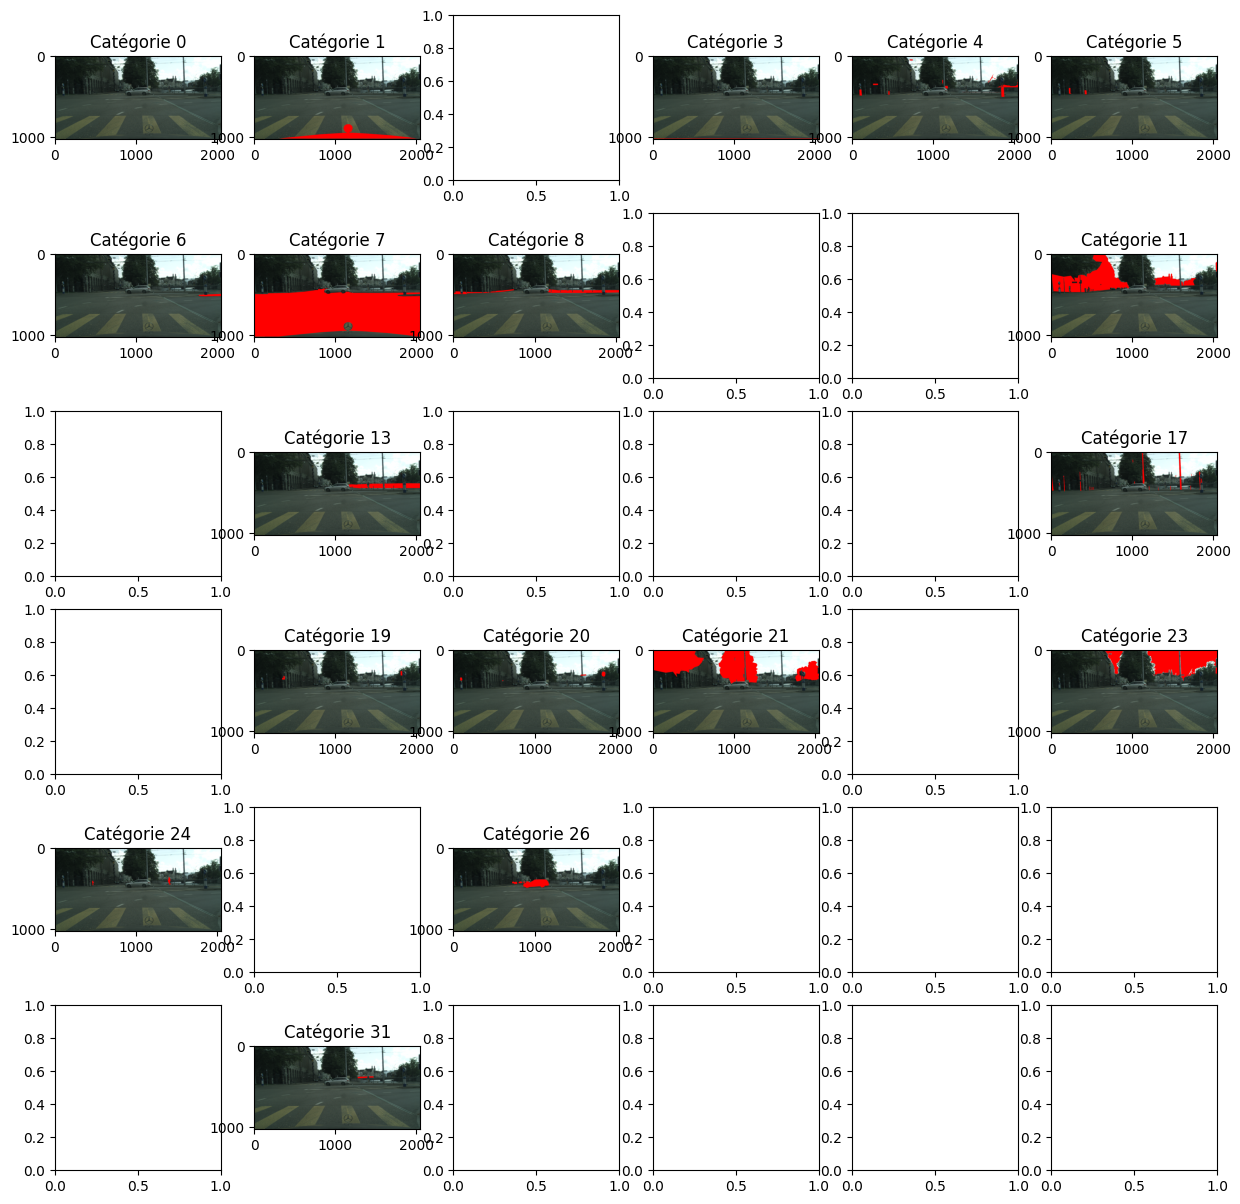

In [280]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(6,6, figsize=(15, 15))
for c in np.unique(labels):
    img_ = img_numpy.copy()
    img_[np.where(labels == c)] = [255, 0, 0]
    ax[c//6, c%6].imshow(Image.fromarray(img_))
    ax[c//6, c%6].title.set_text("Catégorie {}".format(c))
plt.show()

### On va travailler pixel à pixel pour prédire les masks
#### Dans les images labelids, on retrouve chaqu'une des 30 catégories associées à un numéro. On regroupe ces catégories en 8 : véhicules, personnes, sol, végétation, etc.

## Répartition des classes

In [117]:
import glob
import torch
import numpy as np

masks = [np.array(Image.open(p)) for p in glob.glob("zurich/segmented/*_labelIds.png")]
masks_batch = torch.from_numpy(np.array(masks))

In [118]:
from src import utils
import importlib
importlib.reload(utils)
masks_group_batch = utils.group_mask_v2(masks_batch)

In [149]:
import pandas as pd
from src.utils import CATEGORIES_MASK
s = pd.Series(index=list(CATEGORIES_MASK.keys()))
for index, cat_name in enumerate(CATEGORIES_MASK):
    s.loc[cat_name] = int((masks_group_batch[...,index] == 1).sum())

In [121]:
s

void             19947271.0
flat            101914515.0
construction     55441872.0
object            4716010.0
nature           40733910.0
sky               9628046.0
human             3413751.0
vehicle          20057169.0
dtype: float64

<Axes: >

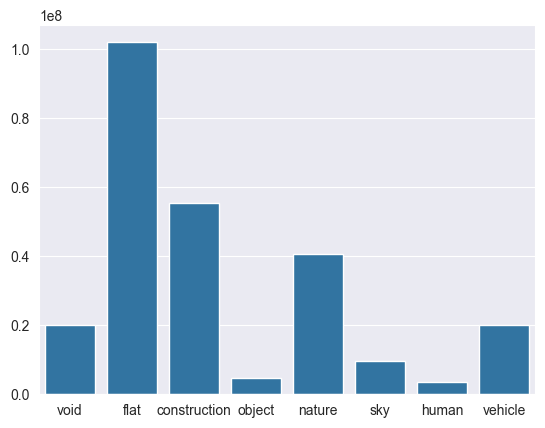

In [122]:
import seaborn as sns
sns.barplot(s)

In [123]:
masks_group_batch_label = utils.group_mask_v2(masks_batch, with_cat_number=True)

In [124]:
masks_concatenate = masks_group_batch_label.view(-1)
masks_concatenate = masks_concatenate.long()
masks_concatenate_clean=masks_concatenate[masks_concatenate>0]

In [125]:
display(masks_concatenate.shape)
masks_concatenate_clean.shape

torch.Size([2046820352])

torch.Size([255852544])

In [126]:
torch.unique(masks_concatenate_clean)

tensor([1, 2, 3, 4, 5, 6, 7, 8])

In [137]:
counts = torch.bincount(masks_concatenate_clean)[1:]
display(counts)

tensor([ 19947271, 101914515,  55441872,   4716010,  40733910,   9628046,
          3413751,  20057169])

In [141]:
N, C = counts.sum(), counts.numel()
w_a = N/(C+counts)
w_b = counts.median()/counts

In [135]:
frequencies = counts.float() / counts.sum()
class_weights = 1.0 / (frequencies + 1e-6)  # pour éviter la division par zéro
class_weights = class_weights / class_weights.sum()  # normalisation (optionnel)

In [136]:
frequencies

tensor([0.0780, 0.3983, 0.2167, 0.0184, 0.1592, 0.0376, 0.0133, 0.0784])

In [129]:
class_weights

tensor([9.9981e-01, 1.2824e-05, 2.5100e-06, 4.6139e-06, 5.4238e-05, 6.2798e-06,
        2.6568e-05, 7.4927e-05, 1.2754e-05])

In [140]:
w_a

tensor([12.8264,  2.5105,  4.6148, 54.2518,  6.2811, 26.5737, 74.9475, 12.7562])

In [150]:
df = pd.DataFrame({'count':s})

In [151]:
df['weight'] =w_b

In [152]:
df

,count,weight
void,19947271.0,1.000000
flat,101914515.0,0.195726
construction,55441872.0,0.359787
object,4716010.0,4.229692
nature,40733910.0,0.489697
sky,9628046.0,2.071788
human,3413751.0,5.843212
vehicle,20057169.0,0.994521


## Vérification de l'image d'entrée dans le neuronne

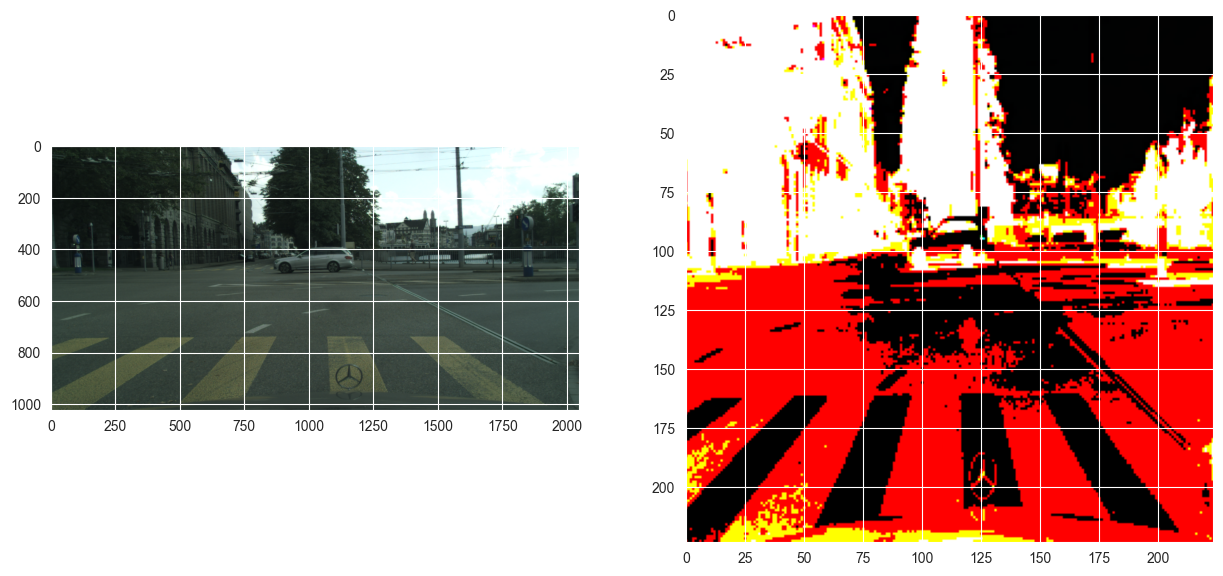

In [112]:
from src.dataset import DatasetVGG16
import matplotlib.pyplot as plt
img = Image.open("zurich/annotat/zurich_000000_000019_leftImg8bit.png")
img_transformed = DatasetVGG16.transform_rgb(img)
img_transformed = img_transformed.permute(1,2,0).numpy().astype(np.uint8)
figure, axes = plt.subplots(1, 2, figsize=(15, 15))
axes[0].imshow(Image.fromarray(np.array(img)))
axes[1].imshow(Image.fromarray(img_transformed))

### On induit une déformation. On constate aussi que la normalisation induit du bruit

## Avec dégradation

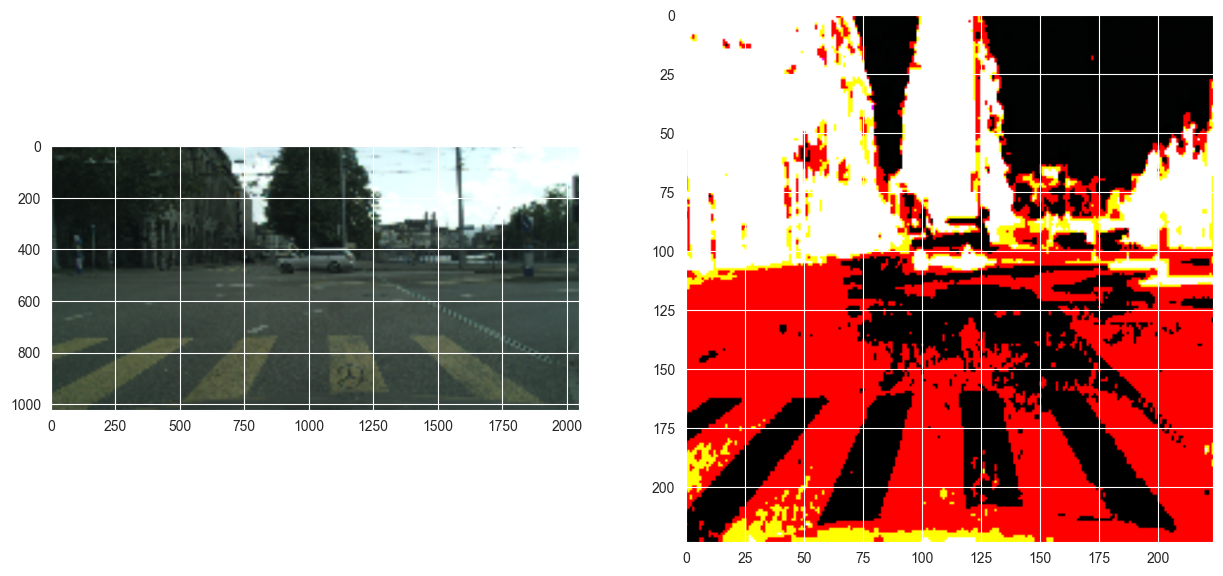

In [107]:
from src.utils import degrade_png_quality
img_d = degrade_png_quality(img)
img_transformed_d = DatasetVGG16.transform_rgb(img_d)
img_transformed_d = img_transformed_d.permute(1,2,0).numpy().astype(np.uint8)
figure, axes = plt.subplots(1, 2, figsize=(15, 15))
axes[0].imshow(img_d)
axes[1].imshow(Image.fromarray(img_transformed_d))

### on induit une déformation, une perte d'information et du bruit

## On coupe une partie de l'image, référence à partir du centre pour qu'elle soit carré

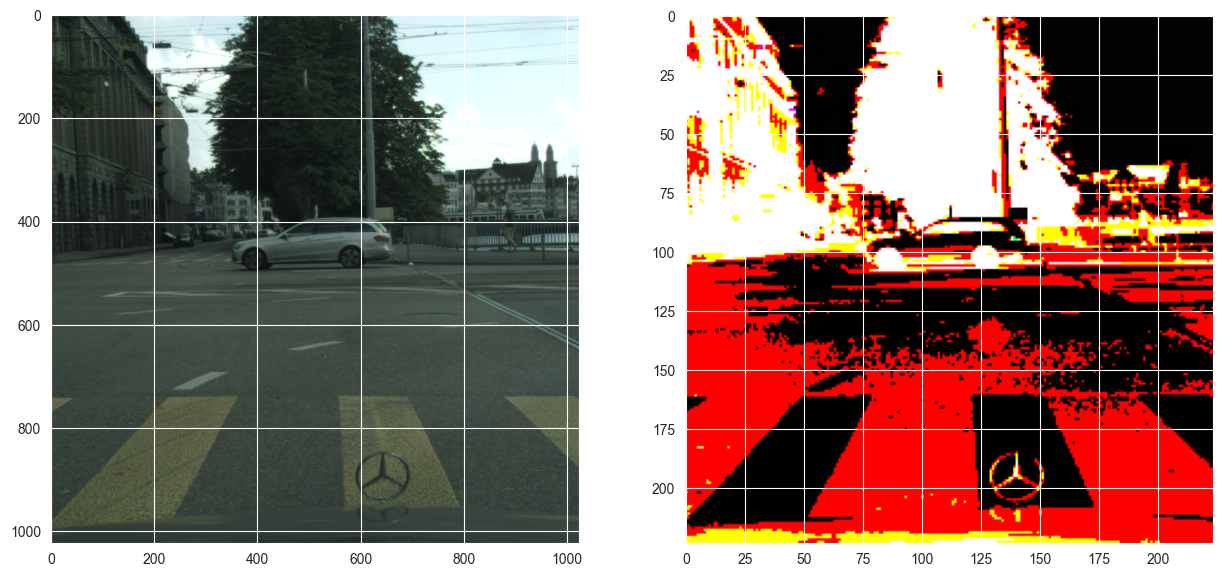

In [108]:
from torchvision.transforms.v2.functional import crop_image
img_c = crop_image(torch.from_numpy(np.array(img)).permute(2,0,1), top=0, left=512, height=1024, width=1024)
img_c = Image.fromarray(img_c.permute(1,2,0).numpy())
img_transformed_c = DatasetVGG16.transform_rgb(img_c)
img_transformed_c = img_transformed_c.permute(1,2,0).numpy().astype(np.uint8)
figure, axes = plt.subplots(1, 2, figsize=(15, 15))
axes[0].imshow(img_c)
axes[1].imshow(Image.fromarray(img_transformed_c))


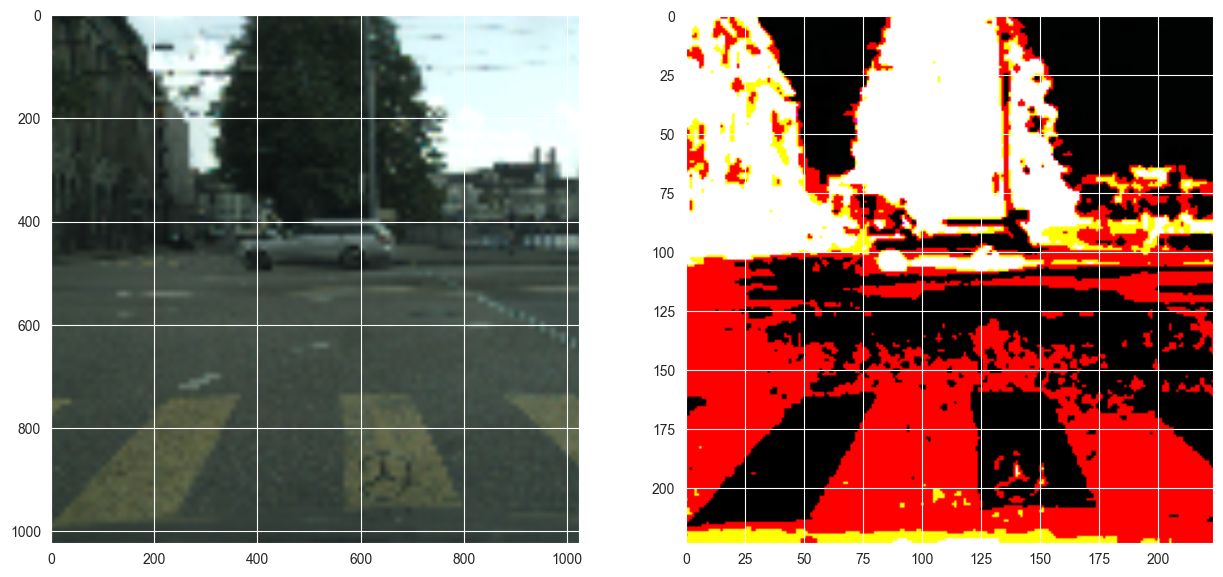

In [109]:
img_d_c = crop_image(torch.from_numpy(np.array(img_d)).permute(2,0,1), top=0, left=512, height=1024, width=1024)
img_d_c = Image.fromarray(img_d_c.permute(1,2,0).numpy())
img_transformed_d_c = DatasetVGG16.transform_rgb(img_d_c)
img_transformed_d_c = img_transformed_d_c.permute(1,2,0).numpy().astype(np.uint8)
figure, axes = plt.subplots(1, 2, figsize=(15, 15))
axes[0].imshow(img_d_c)
axes[1].imshow(Image.fromarray(img_transformed_d_c))

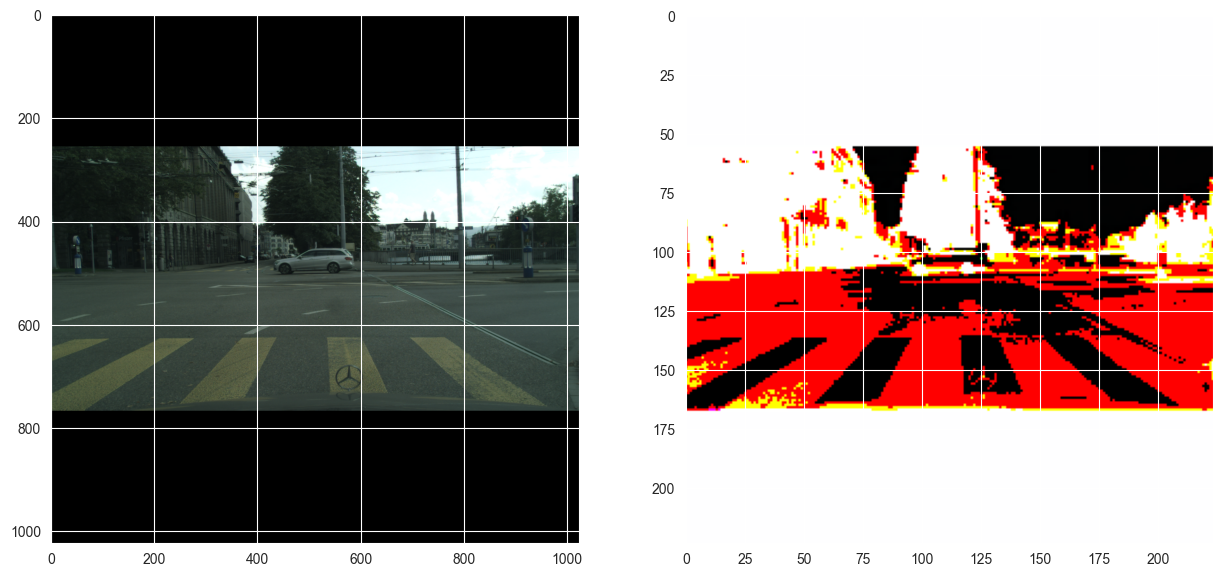

In [114]:
from PIL import ImageOps
def resize_to_square_with_padding(img: Image.Image, size: int, color=(0, 0, 0)) -> Image.Image:
    """Redimensionne l'image en carré sans la déformer (padding)"""
    # Resize en gardant les proportions
    tmp_img = img.copy()
    tmp_img.thumbnail((size, size), Image.Resampling.LANCZOS)

    # Ajouter du padding pour obtenir un carré
    delta_w = size - tmp_img.width
    delta_h = size - tmp_img.height
    padding = (delta_w // 2, delta_h // 2, delta_w - delta_w // 2, delta_h - delta_h // 2)

    return ImageOps.expand(tmp_img, padding, fill=color)

img_r = resize_to_square_with_padding(img, 1024)
img_transformed_r = DatasetVGG16.transform_rgb(img_r)
img_transformed_r = img_transformed_r.permute(1,2,0).numpy().astype(np.uint8)
figure, axes = plt.subplots(1, 2, figsize=(15, 15))
axes[0].imshow(img_r)
axes[1].imshow(Image.fromarray(img_transformed_r))